# Lecture 19: Grand Canonical Monte Carlo Simulations of Competitive Adsorption

## Introduction

In surface science, **competitive adsorption** refers to the scenario where multiple species (adsorbates) compete for adsorption sites on a surface. This phenomenon is crucial in heterogeneous catalysis, separation processes, and sensor technology, where the presence of one adsorbate can significantly influence the adsorption behavior of another.

In this project, you will write a Python program that uses the **grand canonical Monte Carlo** (GCMC) method and the **Metropolis algorithm** to simulate competitive adsorption of two different adsorbate species on a two-dimensional (2D) square lattice. By varying parameters such as chemical potential, temperature, and interaction energies, you will compute the phase diagram of the system.

## Competitive Adsorption on Surfaces

### Two-Component Adsorption Model

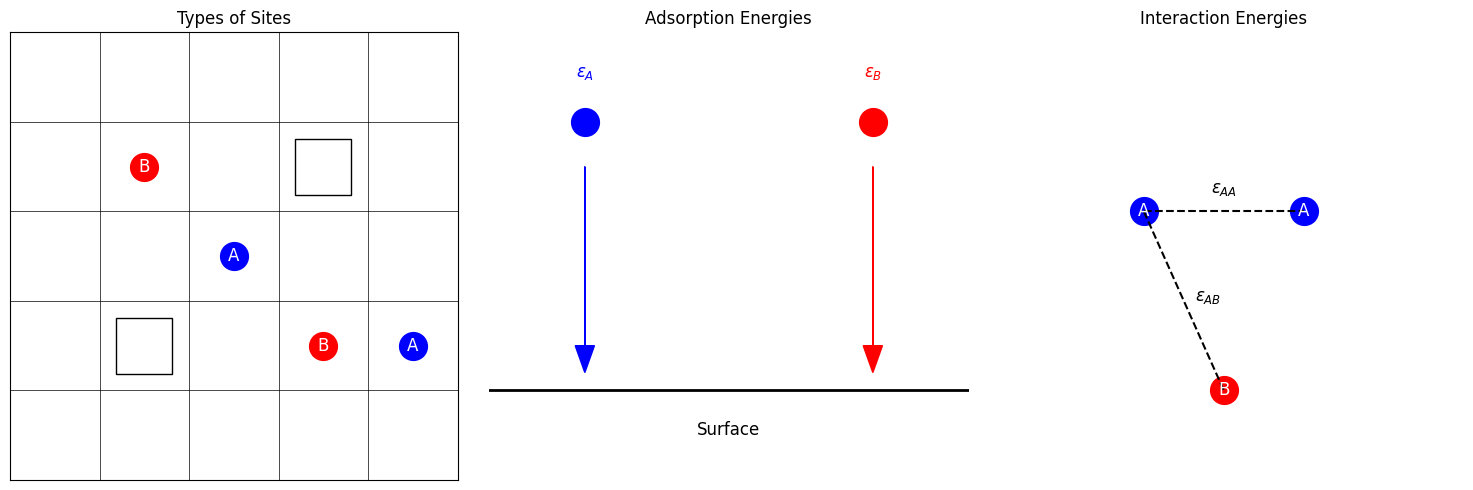

In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np

# Create figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Left panel: Types of Sites
ax = axs[0]
ax.set_title('Types of Sites')
grid_size = 5

# Draw grid
for x in range(grid_size + 1):
    ax.plot([x, x], [0, grid_size], color='black', linewidth=0.5)
for y in range(grid_size + 1):
    ax.plot([0, grid_size], [y, y], color='black', linewidth=0.5)

# Define site types
empty_sites = [(1, 1), (3, 3)]
adsorbate_A_sites = [(2, 2), (4, 1)]
adsorbate_B_sites = [(1, 3), (3, 1)]

# Plot empty sites
for (x, y) in empty_sites:
    ax.plot(x + 0.5, y + 0.5, 's', color='white', markersize=40, markeredgecolor='black')

# Plot adsorbate A sites
for (x, y) in adsorbate_A_sites:
    ax.plot(x + 0.5, y + 0.5, 'o', color='blue', markersize=20)
    ax.text(x + 0.5, y + 0.5, 'A', ha='center', va='center', color='white', fontsize=12)

# Plot adsorbate B sites
for (x, y) in adsorbate_B_sites:
    ax.plot(x + 0.5, y + 0.5, 'o', color='red', markersize=20)
    ax.text(x + 0.5, y + 0.5, 'B', ha='center', va='center', color='white', fontsize=12)

ax.set_xlim(0, grid_size)
ax.set_ylim(0, grid_size)
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])

# Middle panel: Adsorption Energies
ax = axs[1]
ax.set_title('Adsorption Energies')

# Draw surface line
ax.plot([0, 5], [0, 0], color='black', linewidth=2)
ax.text(2.5, -0.5, 'Surface', ha='center', fontsize=12)

# Adsorbate A approaching surface
ax.plot(1, 3, 'o', color='blue', markersize=20)
ax.arrow(1, 2.5, 0, -2.0, head_width=0.2, head_length=0.3, fc='blue', ec='blue')
ax.text(1, 3.5, r'$\epsilon_A$', ha='center', color='blue', fontsize=12)

# Adsorbate B approaching surface
ax.plot(4, 3, 'o', color='red', markersize=20)
ax.arrow(4, 2.5, 0, -2.0, head_width=0.2, head_length=0.3, fc='red', ec='red')
ax.text(4, 3.5, r'$\epsilon_B$', ha='center', color='red', fontsize=12)

ax.set_xlim(0, 5)
ax.set_ylim(-1, 4)
ax.axis('off')

# Right panel: Interaction Energies
ax = axs[2]
ax.set_title('Interaction Energies')

# Adsorbates on surface
ax.plot(2, 2, 'o', color='blue', markersize=20)
ax.text(2, 2, 'A', ha='center', va='center', color='white', fontsize=12)
ax.plot(3, 2, 'o', color='blue', markersize=20)
ax.text(3, 2, 'A', ha='center', va='center', color='white', fontsize=12)
ax.plot(2.5, 1, 'o', color='red', markersize=20)
ax.text(2.5, 1, 'B', ha='center', va='center', color='white', fontsize=12)

# Interaction between A-A
ax.plot([2, 3], [2, 2], color='black', linestyle='--')
ax.text(2.5, 2.1, r'$\epsilon_{AA}$', ha='center', fontsize=12)

# Interaction between A-B
ax.plot([2, 2.5], [2, 1], color='black', linestyle='--')
ax.text(2.4, 1.5, r'$\epsilon_{AB}$', ha='center', fontsize=12)

ax.set_xlim(1, 4)
ax.set_ylim(0.5, 3)
ax.axis('off')

plt.tight_layout()
plt.show()

Consider a 2D square lattice representing the surface, where each lattice site can be **empty** (white squares in the left panel), occupied by **adsorbate A** (blue circles), or occupied by **adsorbate B** (red circles). The adsorption behavior is governed by adsorption energies $\epsilon_A$ and $\epsilon_B$ (middle panel) and interaction energies $\epsilon_{AA}$, $\epsilon_{BB}$, and $\epsilon_{AB}$ (right panel).

### Lattice Model for Two Species

In this lattice model, the total energy of the system is given by

$$
E = \sum_{i} \left( n_i^A \epsilon_A + n_i^B \epsilon_B \right) + \frac{1}{2} \sum_{\langle i,j \rangle} \left( n_i^A n_j^A \epsilon_{AA} + n_i^B n_j^B \epsilon_{BB} + n_i^A n_j^B \epsilon_{AB} + n_i^B n_j^A \epsilon_{AB} \right)
$$

where $n_i^A$ and $n_i^B$ are the number of adsorbates A and B at site $i$, respectively. If site $i$ is empty, $n_i^A = n_i^B = 0$. If site $i$ is occupied by adsorbate A, $n_i^A = 1$ and $n_i^B = 0$. If site $i$ is occupied by adsorbate B, $n_i^A = 0$ and $n_i^B = 1$. The first sum runs over all lattice sites, and the second sum runs over all pairs of neighboring sites. The factor $\frac{1}{2}$ avoids double-counting interactions.

### Grand Canonical Ensemble

In the grand canonical ensemble, this system is open to exchange particles and energy with a reservoir at fixed chemical potentials $\mu_A$ and $\mu_B$ for adsorbates A and B, respectively, and temperature $T$. The probability distribution function for the system is proportional to

$$
P(\{n_i^A, n_i^B\}) \propto \exp\left(-\beta \Omega\right)
$$

where $\Omega$ is the grand potential given by

$$
\Omega = E - \mu_A N_A - \mu_B N_B
$$

and $\beta = \frac{1}{kT}$ is the inverse temperature. The numbers of adsorbates A and B are denoted by $N_A$ and $N_B$, respectively.

## Grand Canonical Monte Carlo (GCMC) Simulations

### Metropolis Algorithm Adapted for GCMC

In the grand canonical ensemble, the Metropolis algorithm is adapted to allow for particle addition and removal moves.

```{admonition} Particle Addition
1. Choose an empty site at random.
2. Decide to add A or B based on predefined probabilities or randomly.
3. Calculate the change in energy $\Delta E$.
4. Include the ratio of proposal probabilities in the acceptance probability.
5. Accept the move with probability

    $$
    \text{acc} = \min\left[1, \frac{N_a - N_s}{N_s + 1} \exp\left(-\beta [\Delta E - \mu_s]\right)\right]
    $$

    where $N_a$ is the number of empty sites, $N_s$ is the number of sites occupied by species $s$, and $\mu_s$ is the chemical potential of species $s$.

6. Update the lattice configuration and particle counts.
```

```{admonition} Particle Removal
1. Choose an occupied site at random.
2. Calculate the change in energy $\Delta E$ for removing the particle.
3. Include the ratio of proposal probabilities in the acceptance probability.
4. Accept the move with probability

    $$
    \text{acc} = \min\left[1, \frac{N_s}{N_a - N_s + 1} \exp\left(-\beta [\Delta E + \mu_s]\right)\right]
    $$

    where $N_a$ is the number of empty sites, $N_s$ is the number of sites occupied by species $s$, and $\mu_s$ is the chemical potential of species $s.

5. Update the lattice configuration and particle counts.
```

### Psuedocode for GCMC Simulation

#### Initialize Lattice

```none
FUNCTION initialize_lattice(size):
    CREATE a 2D array 'lattice' of dimensions size x size
    INITIALIZE all elements of 'lattice' to 0  # 0 represents empty sites
    RETURN 'lattice'
```

#### Compute Neighbor Indices with Periodic Boundary Conditions

```none
FUNCTION compute_neighbor_indices(size):
    CREATE an empty dictionary 'neighbor_indices'
    FOR x FROM 0 TO size - 1:
        FOR y FROM 0 TO size - 1:
            neighbors = [
                ((x - 1) MOD size, y),
                ((x + 1) MOD size, y),
                (x, (y - 1) MOD size),
                (x, (y + 1) MOD size)
            ]
            neighbor_indices[(x, y)] = neighbors
    RETURN 'neighbor_indices'
```

#### Calculate Interaction Energy

```none
FUNCTION calculate_interaction_energy(lattice, site, particle, neighbor_indices, epsilon_AA, epsilon_BB, epsilon_AB):
    SET x, y TO coordinates of 'site'
    SET 'interaction_energy' TO 0
    FOR each 'neighbor' in neighbor_indices[(x, y)]:
        SET 'neighbor_particle' TO lattice[neighbor]
        IF 'neighbor_particle' IS NOT 0:
            IF 'particle' IS 1:  # Particle A
                IF 'neighbor_particle' IS 1:
                    ADD 'epsilon_AA' TO 'interaction_energy'
                ELSE:  # Neighbor is Particle B
                    ADD 'epsilon_AB' TO 'interaction_energy'
            ELSE:  # Particle B
                IF 'neighbor_particle' IS 2:
                    ADD 'epsilon_BB' TO 'interaction_energy'
                ELSE:  # Neighbor is Particle A
                    ADD 'epsilon_AB' TO 'interaction_energy'
    RETURN 'interaction_energy'
```

#### Attempt to Add or Remove a Particle

```none
FUNCTION attempt_move(lattice, N_A, N_B, N_empty, neighbor_indices, params):
    SET 'size' TO dimension of 'lattice'
    SET 'N_sites' TO size * size
    SET 'beta' TO 1 / params['T']
    EXTRACT parameters:
        'epsilon_A', 'epsilon_B', 'epsilon_AA', 'epsilon_BB', 'epsilon_AB', 'mu_A', 'mu_B' FROM 'params'

    DECIDE whether to add or remove a particle (50% chance each)
    IF adding a particle:
        IF 'N_empty' IS 0:
            RETURN 'N_A', 'N_B', 'N_empty'  # No empty sites available
        SELECT a random 'site' from empty sites in 'lattice'
        DECIDE which particle to add (A or B) with equal probability
        IF adding Particle A:
            SET 'particle' TO 1
            SET 'mu' TO 'mu_A'
            SET 'epsilon' TO 'epsilon_A'
            SET 'N_s' TO 'N_A'
        ELSE:  # Adding Particle B
            SET 'particle' TO 2
            SET 'mu' TO 'mu_B'
            SET 'epsilon' TO 'epsilon_B'
            SET 'N_s' TO 'N_B'
        CALCULATE 'delta_E' = 'epsilon' + calculate_interaction_energy(...)
        CALCULATE acceptance probability 'acc_prob' = MIN[1, (N_empty) / (N_s + 1) * exp(-beta * (delta_E - mu))]
        GENERATE a random number 'r' between 0 and 1
        IF 'r' < 'acc_prob':
            SET lattice[site] = 'particle'
            UPDATE counts:
                IF 'particle' IS 1:
                    INCREMENT 'N_A' by 1
                ELSE:
                    INCREMENT 'N_B' by 1
            DECREMENT 'N_empty' by 1
    ELSE:  # Removing a particle
        IF 'N_sites' - 'N_empty' IS 0:
            RETURN 'N_A', 'N_B', 'N_empty'  # No particles to remove
        SELECT a random 'site' from occupied sites in 'lattice'
        GET 'particle' at 'site'
        IF 'particle' IS 1:
            SET 'mu' TO 'mu_A'
            SET 'epsilon' TO 'epsilon_A'
            SET 'N_s' TO 'N_A'
        ELSE:  # Particle B
            SET 'mu' TO 'mu_B'
            SET 'epsilon' TO 'epsilon_B'
            SET 'N_s' TO 'N_B'
        CALCULATE 'delta_E' = -'epsilon' - calculate_interaction_energy(...)
        CALCULATE acceptance probability 'acc_prob' = MIN[1, N_s / (N_empty + 1) * exp(-beta * (delta_E + mu))]
        GENERATE a random number 'r' between 0 and 1
        IF 'r' < 'acc_prob':
            SET lattice[site] = 0  # Remove particle
            UPDATE counts:
                IF 'particle' IS 1:
                    DECREMENT 'N_A' by 1
                ELSE:
                    DECREMENT 'N_B' by 1
            INCREMENT 'N_empty' by 1
    RETURN 'N_A', 'N_B', 'N_empty'
```

#### Run the GCMC Simulation

```none
FUNCTION run_simulation(size, n_steps, params):
    INITIALIZE 'lattice' using initialize_lattice(size)
    COMPUTE 'neighbor_indices' using compute_neighbor_indices(size)
    SET 'N_sites' TO size * size
    INITIALIZE counts:
        'N_A' = 0
        'N_B' = 0
        'N_empty' = 'N_sites'
    CREATE arrays 'coverage_A' and 'coverage_B' of length 'n_steps'

    FOR 'step' FROM 0 TO 'n_steps' - 1:
        UPDATE 'N_A', 'N_B', 'N_empty' by calling attempt_move(...)
        SET coverage_A[step] = 'N_A' / 'N_sites'
        SET coverage_B[step] = 'N_B' / 'N_sites'

    RETURN 'lattice', 'coverage_A', 'coverage_B'
```

#### Plot Lattice Configuration

```none
FUNCTION plot_lattice(lattice, ax, title):
    SET 'size' TO dimension of 'lattice'
    FOR x FROM 0 TO 'size' - 1:
        FOR y FROM 0 TO 'size' - 1:
            IF lattice[x, y] IS 1:
                PLOT a red circle at position (x + 0.5, y + 0.5) on axis 'ax'
            ELSE IF lattice[x, y] IS 2:
                PLOT a blue circle at position (x + 0.5, y + 0.5) on axis 'ax'
    SET axis limits and labels:
        x-axis from 0 to 'size', y-axis from 0 to 'size'
        REMOVE x and y tick labels
        ENABLE minor grid lines
        SET title of 'ax' to 'title'
    RETURN 'ax'
```

## Example Simulation and Phase Diagram

Here is an example Python code snippet that runs a grand canonical Monte Carlo simulation for competitive adsorption on a 2D lattice and generates a phase diagram showing the coverage of adsorbates A and B as a function of chemical potential $\mu_A$ and temperature $T$. The code also plots the final lattice configurations at specific points in the phase diagram.

```python
import numpy as np
import matplotlib.pyplot as plt

# Parameters
size = 4
n_steps = 10000
mus_A = np.linspace(-0.2, 0, 7)
Ts = np.linspace(0.001, 0.019, 7)
params = []
for mu_A in mus_A:
    for T in Ts:
        params.append({
            'epsilon_A': -0.1,
            'epsilon_B': -0.1,
            'epsilon_AA': 0,
            'epsilon_BB': 0,
            'epsilon_AB': 0,
            'mu_A': mu_A,
            'mu_B': -0.1,
            'T': T  # Temperature (in units of k)
        })

# Run the simulation
np.random.seed(42)
final_lattice = np.zeros((len(mus_A), len(Ts), size, size))
mean_coverage_A = np.zeros((len(mus_A), len(Ts)))
mean_coverage_B = np.zeros((len(mus_A), len(Ts)))
for i, param in enumerate(params):
    lattice, coverage_A, coverage_B = run_simulation(size, n_steps, param)
    final_lattice[i // len(Ts), i % len(Ts)] = lattice
    mean_coverage_A[i // len(Ts), i % len(Ts)] = np.mean(coverage_A[-1000:])
    mean_coverage_B[i // len(Ts), i % len(Ts)] = np.mean(coverage_B[-1000:])

# Plot the T-mu_A phase diagram
fig, axs = plt.subplots_mosaic([[0, 1, 2], [3, 4, 5]], figsize=(6.5, 4.5))

# Mean coverage of A
axs[0].pcolormesh(mus_A, Ts, mean_coverage_A.T, cmap='viridis', vmin=0, vmax=1)
axs[0].set_title(r'$\langle \theta_A \rangle$')
axs[0].set_xlabel(r'$\mu_A$')
axs[0].set_ylabel(r'$T$')

# Mean coverage of B
axs[1].pcolormesh(mus_A, Ts, mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[1].set_title(r'$\langle \theta_B \rangle$')
axs[1].set_xlabel(r'$\mu_A$')
axs[1].set_yticks([])

# Mean total coverage
cax = axs[2].pcolormesh(mus_A, Ts, mean_coverage_A.T + mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[2].set_title(r'$\langle \theta_A + \theta_B \rangle$')
axs[2].set_xlabel(r'$\mu_A$')
axs[2].set_yticks([])
fig.colorbar(cax, ax=axs[2], location='right', fraction=0.1)

# Plot the final lattice configuration

# mu_A = -0.2 eV and T = 0.01 / k
axs[3] = plot_lattice(final_lattice[0, 3], axs[3], r'$\mu_A = -0.2$ eV, $T = 0.01 / k$')

# mu_A = -0.1 eV and T = 0.01 / k
axs[4] = plot_lattice(final_lattice[3, 3], axs[4], r'$\mu_A = -0.1$ eV, $T = 0.01 / k$')

# mu_A = 0 eV and T = 0.01 / k
axs[5] = plot_lattice(final_lattice[6, 3], axs[5], r'$\mu_A = 0$ eV, $T = 0.01 / k$')

plt.tight_layout()
plt.show()
```

![Phase Diagram](project-1.png)

The phase diagram shows the mean coverage of adsorbates A and B on the surface as a function of chemical potential $\mu_A$ and temperature $T$. The lattice configurations at specific points in the phase diagram illustrate the adsorption behavior of the two species under different conditions.

## Project Description

### Scenario

You work for a chemical company that produces ammonia using the Haber-Bosch process. The company is interested in understanding the competitive adsorption of nitrogen and hydrogen on the catalyst surface to optimize the reaction conditions. Your task is to simulate the adsorption behavior of nitrogen and hydrogen on a 2D lattice and analyze the effects of varying chemical potentials and interaction energies. The company wants you to provide a detailed report on the phase diagram of the system and the implications for the ammonia synthesis process.

You decide to use a grand canonical Monte Carlo simulation to model the competitive adsorption of nitrogen and hydrogen on a 2D square lattice. You will vary the chemical potential of hydrogen ($\mu_{\text{H}}$) and hold the chemical potential of nitrogen ($\mu_{\text{N}}$) constant because nitrogen is in excess in the reaction. You do not know the exact values of the adsorption and interaction energies, so you will explore a range of parameters to understand the system's behavior. You will generate phase diagrams showing the coverage of nitrogen and hydrogen on the surface and analyze how different parameters affect the adsorption behavior. Finally, you will write a report summarizing your findings and discussing the implications for the ammonia synthesis process.

You decide to explore the following sets of parameters:

- Ideal Mixture of Nitrogen and Hydrogen:
  - $\epsilon_{\text{N}} = -0.1$ eV, $\epsilon_{\text{H}} = -0.1$ eV
  - $\epsilon_{\text{NN}} = 0$ eV, $\epsilon_{\text{HH}} = 0$ eV, $\epsilon_{\text{NH}} = 0$ eV
- Repulsive Interactions between Nitrogen and Hydrogen:
  - $\epsilon_{\text{N}} = -0.1$ eV, $\epsilon_{\text{H}} = -0.1$ eV
  - $\epsilon_{\text{NN}} = 0.05$ eV, $\epsilon_{\text{HH}} = 0.05$ eV, $\epsilon_{\text{NH}} = 0.05$ eV
- Attractive Interactions between Nitrogen and Hydrogen:
  - $\epsilon_{\text{N}} = -0.1$ eV, $\epsilon_{\text{H}} = -0.1$ eV
  - $\epsilon_{\text{NN}} = -0.05$ eV, $\epsilon_{\text{HH}} = -0.05$ eV, $\epsilon_{\text{NH}} = -0.05$ eV
- Immiscible Nitrogen and Hydrogen:
  - $\epsilon_{\text{N}} = -0.1$ eV, $\epsilon_{\text{H}} = -0.1$ eV
  - $\epsilon_{\text{NN}} = -0.05$ eV, $\epsilon_{\text{HH}} = -0.05$ eV, $\epsilon_{\text{NH}} = 0.05$ eV
- "Like Dissolves Unlike" Scenario:
  - $\epsilon_{\text{N}} = -0.1$ eV, $\epsilon_{\text{H}} = -0.1$ eV
  - $\epsilon_{\text{NN}} = 0.05$ eV, $\epsilon_{\text{HH}} = 0.05$ eV, $\epsilon_{\text{NH}} = -0.05$ eV

You will run the simulation for each set of parameters and generate phase diagrams showing the coverage of nitrogen and hydrogen on the surface. You will analyze the phase diagrams and discuss the implications of the results for the ammonia synthesis process. Your report should include figures of the phase diagrams and lattice configurations for each parameter set and a detailed discussion of the physical interpretation of the results. You should also discuss how the competitive adsorption behavior of nitrogen and hydrogen influences the ammonia synthesis process and suggest potential strategies for optimizing the reaction conditions.

### Requirements

```{admonition} Implementation
:class: tip
- Use the provided pseudocode as a guide to implement the grand canonical Monte Carlo simulation for competitive adsorption.
- Use the provided example code snippet to test your implementation.
```

```{admonition} Phase Diagrams
:class: tip
- Use the provided `mus_A` and `Ts` arrays to explore the parameter space and generate phase diagrams showing the coverage of nitrogen and hydrogen on the surface.
- Plot the mean coverage of nitrogen, hydrogen, and the total coverage as a function of chemical potential $\mu_{\text{H}}$ and temperature $T$.
- Include color bars to indicate the coverage values in the phase diagrams.
```

```{admonition} Analysis
:class: tip
- Analyze the phase diagrams and discuss the adsorption behavior of nitrogen and hydrogen under different conditions.
- Compare the phase diagrams for the different parameter sets and discuss the effects of varying adsorption and interaction energies.
- Discuss the implications of the results for the ammonia synthesis process and suggest strategies for optimizing the reaction conditions.
```

```{admonition} Report
:class: tip
- Write a report summarizing your findings.
- Include figures of the phase diagrams and lattice configurations for each parameter set.
- Discuss the physical interpretation of the results and the implications for the ammonia synthesis process.
```

```{admonition} Submission
:class: tip
- Push your code and report to the project repository on GitHub.
- Submit the project repository link to the course portal.
```

### Optional Enhancements (Five Bonus Points Each)

- Implement additional moves such as particle swaps to enhance the simulation.
- Explore more complex lattice geometries (e.g., triangular or hexagonal lattices) and interaction schemes.
- Investigate the effects of lattice size on the adsorption behavior and phase diagrams.
- Extend the simulation to include more than two adsorbate species and study the competitive adsorption behavior.
- Implement a visualization tool to animate the adsorption process and observe the stochastic behavior of the system.